In [1]:
import kan
import kan.utils as ku
import torch
import torch.nn as nn
import numpy as np
from libraries import utils
from libraries import magnetization
import numpy.random as npr
import qutip as qt
import sympy
import random

In [2]:
def J1J2_hamiltonian(N, j1, j2):
    id = qt.qeye(2)
    x = qt.sigmax()
    y = qt.sigmay()
    z = qt.sigmaz()
    sxi = []; syi = []; szi = []
    for i in range(N):
        sxi.append(qt.tensor([id] * i + [x] + [id] * (N - i - 1)))
        syi.append(qt.tensor([id] * i + [y] + [id] * (N - i - 1)))
        szi.append(qt.tensor([id] * i + [z] + [id] * (N - i - 1)))
    sis = [sxi, syi, szi]
    J1_term = j1 * (sum(sis[coord][i] * sis[coord][i + 1] for coord in range(len(sis)) for i in range(N - 1)) + sum(sis[coord][N - 1] * sis[coord][0] for coord in range(len(sis))))
    J2_term = j2 * (sum(sis[coord][i] * sis[coord][i + 2] for coord in range(len(sis)) for i in range(N - 2)) + sum(sis[coord][N - 2] * sis[coord][0] for coord in range(len(sis))) + sum(sis[coord][N - 1] * sis[coord][1] for coord in range(len(sis))))
    return J1_term + J2_term

def count_half_magnetization(state): 
    """
    Counts number of 1s in binary representation of some integer
    With integer encoding of state such that 1 in binary representation 
    is spin down and 0 is spin up. Returns number of spin downs.
    """
    if state == 0: return 0
    return sum((state >> n) & 1 for n in range(0, int(np.log2(state)) + 1, 2))

In [3]:
N=10
input = utils.generate_input_torch(N)
labels = torch.tensor([-1 + 2 * (count_half_magnetization(i) % 2) for i in range(2 ** N)]).reshape((-1, 1))
# pos = [1, 0]; neg = [0, 1]
# labels = torch.tensor([[neg, pos][count_half_magnetization(i) % 2] for i in range(2 ** N)]) 

In [4]:
input.shape, labels.shape

(torch.Size([1024, 10]), torch.Size([1024, 1]))

checkpoint directory created: ./model
saving model version 0.0


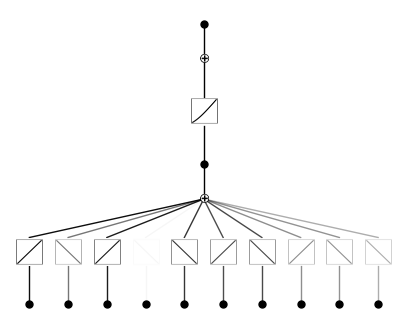

In [5]:
dataset = {'train_input': input, 'train_label': labels, 'test_input': input, 'test_label': labels}
kan_model = kan.KAN(width = [N, 1, 1])
kan_model(dataset['train_input']);
kan_model.plot()

In [6]:
kan_model.symbolic_fun[1].affine

Parameter containing:
tensor([[[0., 0., 0., 0.]]], requires_grad=True)

In [7]:
kan_model.fix_symbolic(1, 0, 0, lambda x : torch.cos(x));

saving model version 0.1


In [8]:
kan_model.symbolic_fun[1].affine

Parameter containing:
tensor([[[1., 0., 1., 0.]]], requires_grad=True)

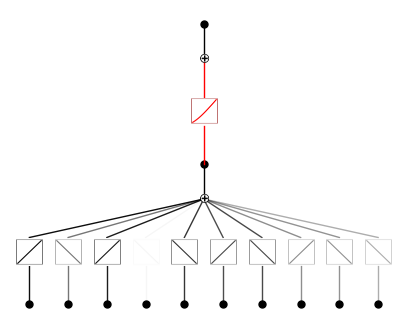

In [9]:
kan_model.plot()

In [10]:
kan_model.symbolic_fun[1].affine = nn.Parameter(torch.tensor([[[torch.pi, 0, 1, 0]]], dtype=torch.float64), requires_grad=False)
kan_model.symbolic_fun[1].affine

Parameter containing:
tensor([[[3.1416, 0.0000, 1.0000, 0.0000]]], dtype=torch.float64)

In [11]:
kan_model.fit(dataset, opt='LBFGS', steps=50);

| train_loss: 1.00e+00 | test_loss: 1.00e+00 | reg: 3.78e-05 | : 100%|█| 50/50 [00:04<00:00, 10.41it

saving model version 0.2


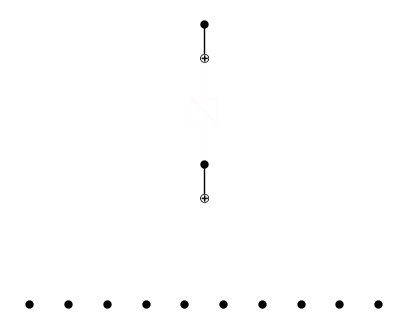

In [12]:
kan_model.plot()

In [13]:
def symbolic_formula(self, var=None, normalizer=None, output_normalizer = None):
    '''
    get symbolic formula

    Args:
    -----
        var : None or a list of sympy expression
            input variables
        normalizer : [mean, std]
        output_normalizer : [mean, std]
        
    Returns:
    --------
        None

    Example
    -------
    >>> from kan import *
    >>> model = KAN(width=[2,1,1], grid=5, k=3, noise_scale=0.0, seed=0)
    >>> f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]])+x[:,[1]]**2)
    >>> dataset = create_dataset(f, n_var=3)
    >>> model.fit(dataset, opt='LBFGS', steps=20, lamb=0.001);
    >>> model.auto_symbolic()
    >>> model.symbolic_formula()[0][0]
    '''
    
    symbolic_acts = []
    symbolic_acts_premult = []
    x = []

    def ex_round(ex1, n_digit):
        ex2 = ex1
        for a in sympy.preorder_traversal(ex1):
            if isinstance(a, sympy.Float):
                ex2 = ex2.subs(a, round(a, n_digit))
        return ex2

    # define variables
    if var == None:
        for ii in range(1, self.width[0][0] + 1):
            exec(f"x{ii} = sympy.Symbol('x_{ii}')")
            exec(f"x.append(x{ii})")
    elif isinstance(var[0], sympy.Expr):
        x = var
    else:
        x = [sympy.symbols(var_) for var_ in var]

    x0 = x

    if normalizer != None:
        mean = normalizer[0]
        std = normalizer[1]
        x = [(x[i] - mean[i]) / std[i] for i in range(len(x))]

    symbolic_acts.append(x)

    for l in range(len(self.width_in) - 1):
        num_sum = self.width[l + 1][0]
        num_mult = self.width[l + 1][1]
        y = []
        for j in range(self.width_out[l + 1]):
            yj = 0.
            for i in range(self.width_in[l]):
                a, b, c, d = self.symbolic_fun[l].affine[j, i]
                sympy_fun = self.symbolic_fun[l].funs_sympy[j][i]
                try:
                    yj += c * sympy_fun(a * x[i] + b) + d
                except:
                    print('vars', a, b, c, d)
                    yj += c * sympy.tanh(a * x[i] + b) + d
                    print('make sure all activations need to be converted to symbolic formulas first!')
                    # return
            yj = self.subnode_scale[l][j] * yj + self.subnode_bias[l][j]
            y.append(yj)
                
        symbolic_acts_premult.append(y)
        
        print(l, y)

        mult = []
        for k in range(num_mult):
            if isinstance(self.mult_arity, int):
                mult_arity = self.mult_arity
            else:
                mult_arity = self.mult_arity[l+1][k]
            for i in range(mult_arity-1):
                if i == 0:
                    mult_k = y[num_sum+2*k] * y[num_sum+2*k+1]
                else:
                    mult_k = mult_k * y[num_sum+2*k+i+1]
            mult.append(mult_k)
            
        y = y[:num_sum] + mult
        
        for j in range(self.width_in[l+1]):
            y[j] = self.node_scale[l][j] * y[j] + self.node_bias[l][j]
        
        x = y
        symbolic_acts.append(x)

    print(symbolic_acts)
    if output_normalizer != None:
        print('here')
        output_layer = symbolic_acts[-1]
        means = output_normalizer[0]
        stds = output_normalizer[1]

        assert len(output_layer) == len(means), 'output_normalizer does not match the output layer'
        assert len(output_layer) == len(stds), 'output_normalizer does not match the output layer'
        
        output_layer = [(output_layer[i] * stds[i] + means[i]) for i in range(len(output_layer))]
        symbolic_acts[-1] = output_layer


    self.symbolic_acts = [[symbolic_acts[l][i] for i in range(len(symbolic_acts[l]))] for l in range(len(symbolic_acts))]
    self.symbolic_acts_premult = [[symbolic_acts_premult[l][i] for i in range(len(symbolic_acts_premult[l]))] for l in range(len(symbolic_acts_premult))]

    out_dim = len(symbolic_acts[-1])
    #return [symbolic_acts[-1][i] for i in range(len(symbolic_acts[-1]))], x0
    return [symbolic_acts[-1][i] for i in range(len(symbolic_acts[-1]))], x0

In [16]:
ku.ex_round(symbolic_formula(kan_model)[0][0], 4)

0 [0]
vars tensor(3.1416, dtype=torch.float64) tensor(0., dtype=torch.float64) tensor(1., dtype=torch.float64) tensor(0., dtype=torch.float64)
make sure all activations need to be converted to symbolic formulas first!
1 [0]
[[x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9, x_10], [0], [0]]


0

In [ ]:
fix_cos_tanh = kan.KAN(width = [N, 1, 1, 1])
fix_cos_tanh(dataset['train_input'])
fix_cos_tanh.fix_symbolic(2, 0, 0, lambda x : torch.tanh(x))
fix_cos_tanh.symbolic_fun[2].affine = nn.Parameter(torch.tensor([[[1, 0, 1, 0]]], dtype = torch.float64), requires_grad=False)
fix_cos_tanh.fix_symbolic(1, 0, 0, lambda x : torch.cos(x))
fix_cos_tanh.symbolic_fun[1].affine = nn.Parameter(torch.tensor([[[torch.pi, 0, 10, 0]]], dtype = torch.float64), requires_grad=False) 
# 25 gets the right nodes but cos isn't really learned, 10 also does this, 5 for some reason doesn't get alternating nodes, and 2 just gets to all 0

checkpoint directory created: ./model
saving model version 0.0
saving model version 0.1
saving model version 0.2


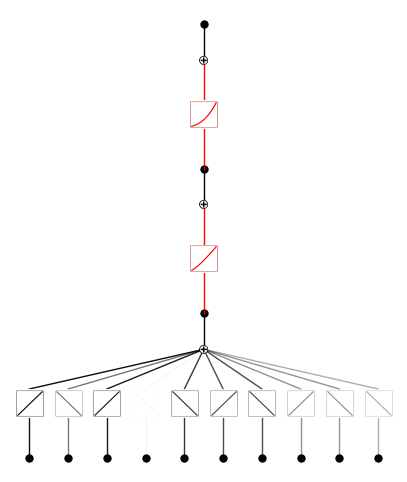

In [82]:
fix_cos_tanh.plot()

In [83]:
fix_cos_tanh.fit(dataset, steps = 50, lamb=0.001);

| train_loss: 1.37e+00 | test_loss: 1.37e+00 | reg: 3.93e+00 | : 100%|█| 50/50 [00:12<00:00,  3.89it

saving model version 0.3


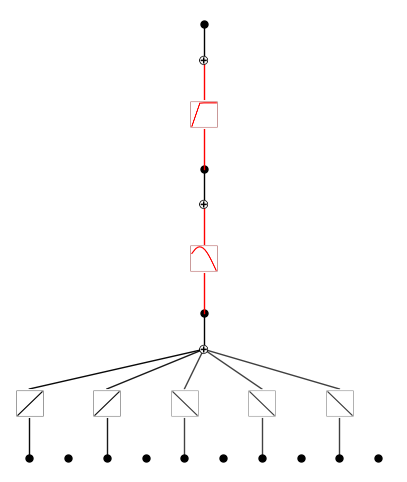

In [84]:
fix_cos_tanh.plot()

saving model version 0.4


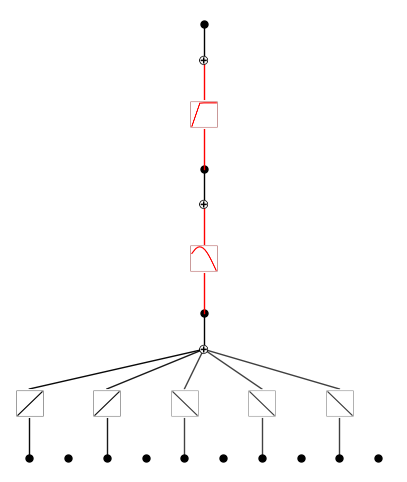

In [85]:
fix_cos_tanh.prune().plot()

In [86]:
fix_cos_tanh = fix_cos_tanh.prune()
fix_cos_tanh.symbolic_fun[1].affine = nn.Parameter(fix_cos_tanh.symbolic_fun[1].affine.data, requires_grad=False)
fix_cos_tanh.symbolic_fun[2].affine = nn.Parameter(fix_cos_tanh.symbolic_fun[2].affine.data, requires_grad=False)
fix_cos_tanh.auto_symbolic()

saving model version 0.4
fixing (0,0,0) with x, r2=1.0000011920928955, c=1
fixing (0,1,0) with 0
fixing (0,2,0) with x, r2=1.000001311302185, c=1
fixing (0,3,0) with 0
fixing (0,4,0) with x, r2=1.0000011920928955, c=1
fixing (0,5,0) with 0
fixing (0,6,0) with x, r2=1.0000009536743164, c=1
fixing (0,7,0) with 0
fixing (0,8,0) with x, r2=1.0000009536743164, c=1
fixing (0,9,0) with 0
skipping (1,0,0) since already symbolic
skipping (2,0,0) since already symbolic
saving model version 0.5


In [87]:
fix_cos_tanh.fit(dataset, steps=50);

| train_loss: 1.27e+00 | test_loss: 1.27e+00 | reg: 0.00e+00 | : 100%|█| 50/50 [00:08<00:00,  6.21it

saving model version 0.6


In [88]:
fix_cos_tanh.symbolic_fun[1].affine

Parameter containing:
tensor([[[ 3.1416,  0.0000, 10.0000,  0.0000]]], dtype=torch.float64)

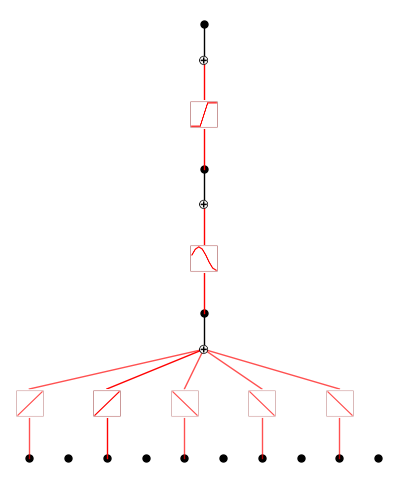

In [89]:
fix_cos_tanh.plot()

In [90]:
ku.ex_round(symbolic_formula(fix_cos_tanh)[0][0], 4)

0 [0.200648476854326*x_1 + 0.60181874848471*x_3 - 0.200791096856694*x_5 - 0.200707439480347*x_7 - 0.200787554774125*x_9 + 0.200956959139792]
vars tensor(3.1416, dtype=torch.float64) tensor(0., dtype=torch.float64) tensor(10., dtype=torch.float64) tensor(0., dtype=torch.float64)
make sure all activations need to be converted to symbolic formulas first!
1 [10.0*tanh(0.630355780839532*x_1 + 1.89066935903217*x_3 - 0.630803834791226*x_5 - 0.630541017392275*x_7 - 0.63079270701065*x_9 + 0.631324906521314)]
vars tensor(1., dtype=torch.float64) tensor(0., dtype=torch.float64) tensor(1., dtype=torch.float64) tensor(0., dtype=torch.float64)
make sure all activations need to be converted to symbolic formulas first!
2 [1.0*tanh(10.0*tanh(0.630355780839532*x_1 + 1.89066935903217*x_3 - 0.630803834791226*x_5 - 0.630541017392275*x_7 - 0.63079270701065*x_9 + 0.631324906521314))]
[[x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9, x_10], [0.200648476854326*x_1 + 0.60181874848471*x_3 - 0.200791096856694*x_5 - 

1.0*tanh(10.0*tanh(0.6304*x_1 + 1.8907*x_3 - 0.6308*x_5 - 0.6305*x_7 - 0.6308*x_9 + 0.6313))